# CFC gray tiny


# Dataset creation

Extracting and making it gray is done in cfc_gray notebook. Here we make it tiny:

# Make CFC_gray_tiny

This data set only includes images nad labels from LeftNear ans LeftFarStratum1

In [ ]:
import shutil
from pathlib import Path

# --- CONFIG ---
SRC_ROOT = Path("../data/CFC_gray")
DST_ROOT = Path("../data/CFC_gray_tiny")
SUBSETS = ["train", "val"]     # we’ll process both splits
IMAGE_DIR = "images"
LABEL_DIR = "labels"
IMAGE_EXTS = {".jpg", ".jpeg", ".png"}
KEEP_PATTERNS = ("LeftFar_Stratum1", "LeftNear_Stratum1")

# --- MAKE DESTINATION LAYOUT ---
for subset in SUBSETS:
    (DST_ROOT / IMAGE_DIR / subset).mkdir(parents=True, exist_ok=True)
    (DST_ROOT / LABEL_DIR / subset).mkdir(parents=True, exist_ok=True)

def should_keep(name: str) -> bool:
    return any(p in name for p in KEEP_PATTERNS)

def copy_pair(img_path: Path, lbl_path: Path, subset: str):
    dst_img = DST_ROOT / IMAGE_DIR / subset / img_path.name
    dst_lbl = DST_ROOT / LABEL_DIR / subset / lbl_path.name
    shutil.copy2(img_path, dst_img)
    shutil.copy2(lbl_path, dst_lbl)

# --- PROCESS ---
skipped_no_label = 0
copied = 0

for subset in SUBSETS:
    img_dir = SRC_ROOT / IMAGE_DIR / subset
    lbl_dir = SRC_ROOT / LABEL_DIR / subset

    if not img_dir.exists() or not lbl_dir.exists():
        print(f"Warning: missing {img_dir} or {lbl_dir}; skipping this subset.")
        continue

    for img_path in img_dir.iterdir():
        if img_path.suffix.lower() not in IMAGE_EXTS:
            continue
        if not should_keep(img_path.name):
            continue

        lbl_path = lbl_dir / (img_path.stem + ".txt")
        if not lbl_path.exists():
            skipped_no_label += 1
            # If you want to keep images even without labels, comment the next line and uncomment copy of image only.
            # shutil.copy2(img_path, DST_ROOT / IMAGE_DIR / subset / img_path.name)
            continue

        copy_pair(img_path, lbl_path, subset)
        copied += 1

print(f"Done. Copied {copied} image/label pairs. Skipped {skipped_no_label} images without labels.")
print(f"New dataset at: {DST_ROOT.resolve()}")


### Write yaml

In [ ]:
from pathlib import Path

# Base paths
NOT_ROOT = Path.cwd()
ROOT = NOT_ROOT.parent

DATA = ROOT / "data" / "CFC_gray_tiny"

IMAGES_TRAIN = DATA / "images" / "train"
IMAGES_VAL   = DATA    / "images" / "val"


# Build YAML (classic YOLO: train/val/test point to images dirs)
dataset_yaml = f"""
path: {DATA.as_posix()}
train: {IMAGES_TRAIN.as_posix()}
val:   {IMAGES_VAL.as_posix()}


nc: 1
names: 
    - fish
"""

# Write YAML next to the dataset
yaml_path = DATA / "cfc_gray_tiny.yaml"
yaml_path.write_text(dataset_yaml.strip() + "\n", encoding="utf-8")

print("Wrote:", yaml_path)
print("\nPreview:\n")
print(dataset_yaml)


### Visualize

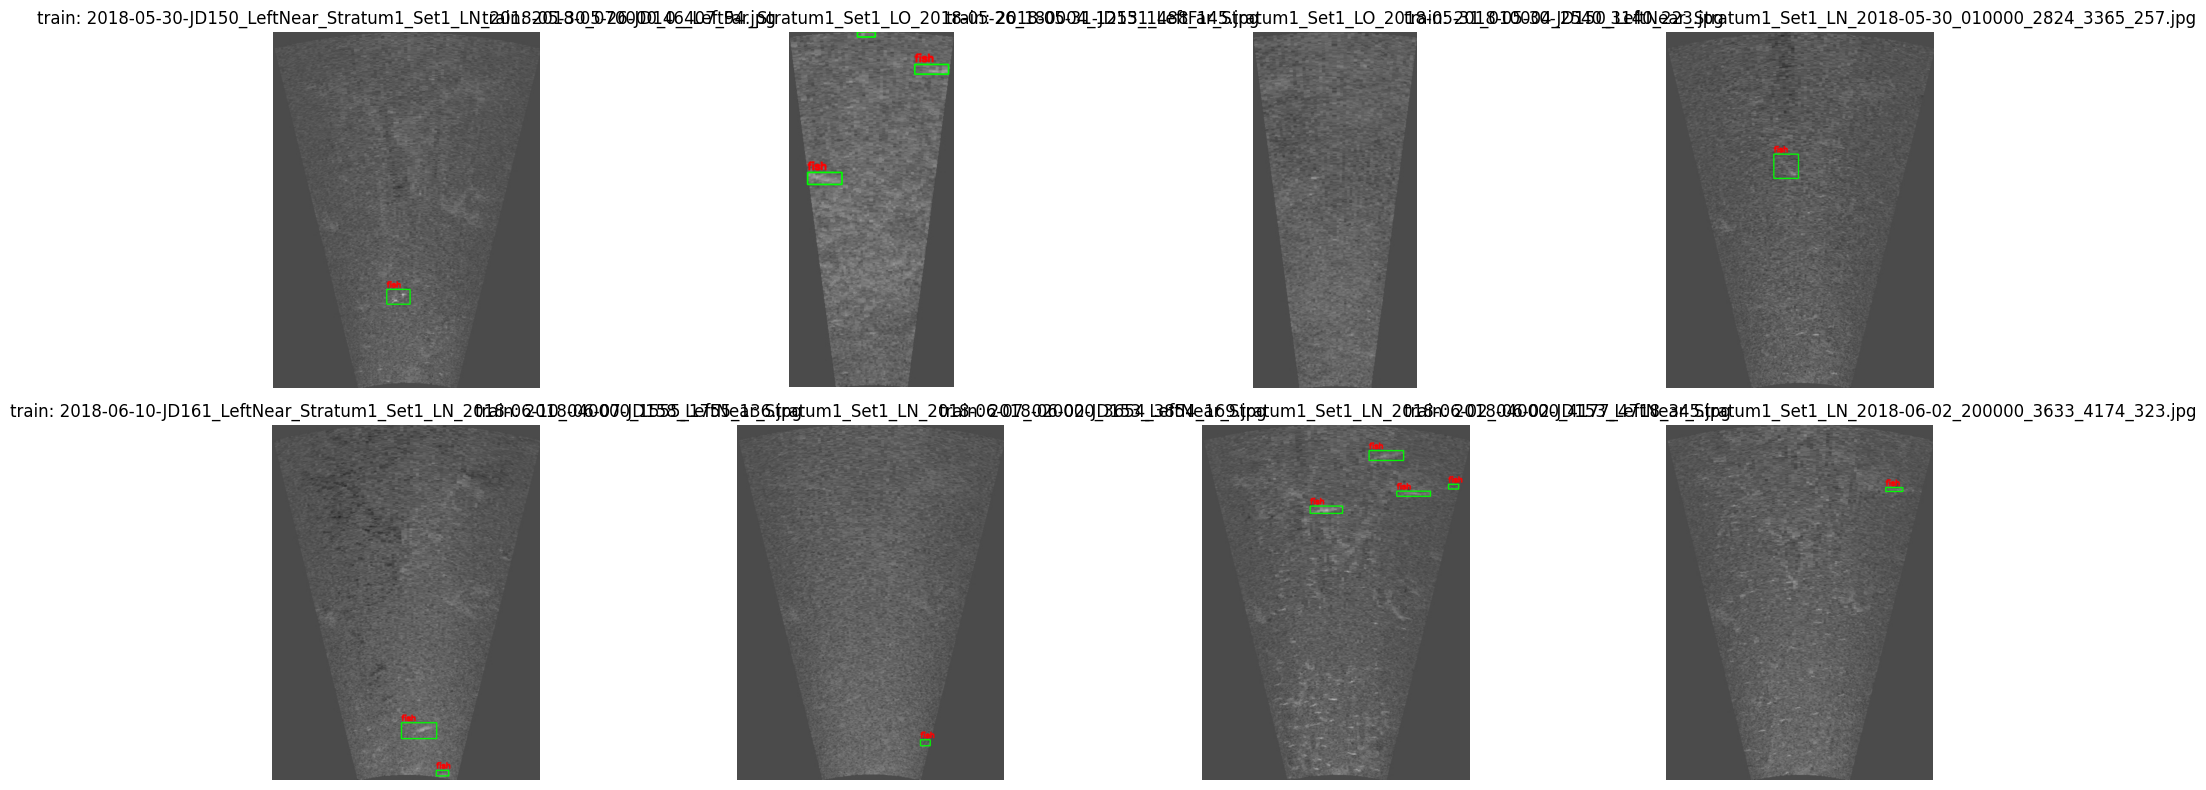

In [1]:
import os, math, random, re
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

# ---------------- config ----------------
DATA_ROOT = Path("../data/CFC_gray_tiny")
IMG_ROOT  = DATA_ROOT / "images"
LAB_ROOT  = DATA_ROOT / "labels"

SPLIT = "train"   # "train" or "test"
IMG_DIR = IMG_ROOT / SPLIT
LAB_DIR = LAB_ROOT / SPLIT

NUM_PICS = 8
COLS = 4


CFC_NAMES = [
    "fish"
]
# ----------------------------------------

def find_images(folder: Path):
    exts = (".jpg",".jpeg",".png",".bmp",".tif",".tiff")
    return [p for p in folder.rglob("*") if p.suffix.lower() in exts]

def label_path_for(img_path: Path) -> Path:
    return LAB_DIR / (img_path.stem + ".txt")

def draw_yolo_labels(image_bgr, label_file: Path, names):
    img = image_bgr.copy()
    h, w = img.shape[:2]
    if not label_file.exists():
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for line in label_file.read_text().splitlines():
        line = line.strip()
        if not line:
            continue
        # YOLO format: class cx cy w h (normalized 0..1)
        parts = re.split(r"\s+", line)
        if len(parts) < 5:
            continue
        cls = int(float(parts[0]))
        cx, cy, bw, bh = map(float, parts[1:5])

        x1 = int((cx - bw/2) * w); y1 = int((cy - bh/2) * h)
        x2 = int((cx + bw/2) * w); y2 = int((cy + bh/2) * h)
        x1 = max(0, min(w-1, x1)); y1 = max(0, min(h-1, y1))
        x2 = max(0, min(w-1, x2)); y2 = max(0, min(h-1, y2))

        color = (0,255,0)
        cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
        label = names[cls] if 0 <= cls < len(names) else f"id{cls}"
        cv2.putText(img, label, (x1, max(0, y1-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2, cv2.LINE_AA)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# collect images that exist (optionally: require label file exists too)
all_imgs = find_images(IMG_DIR)
imgs_with_labels = [p for p in all_imgs if label_path_for(p).exists()]
pool = imgs_with_labels if imgs_with_labels else all_imgs

if not pool:
    raise FileNotFoundError(f"No images found in {IMG_DIR}")

sample_ids = random.sample(pool, min(NUM_PICS, len(pool)))
rows = math.ceil(len(sample_ids) / COLS)

plt.figure(figsize=(5*COLS, 4*rows))
for idx, img_path in enumerate(sample_ids, 1):
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        continue
    lab_path = label_path_for(img_path)
    vis = draw_yolo_labels(img_bgr, lab_path, CFC_NAMES)

    plt.subplot(rows, COLS, idx)
    plt.imshow(vis)
    plt.axis("off")
    plt.title(f"{SPLIT}: {img_path.name}")
plt.tight_layout(); plt.show()


### Dataset summary


In [ ]:
from pathlib import Path
from collections import Counter, defaultdict

ROOT = Path("../data/CFC_gray_tiny")
SUBSETS = ["train", "val"]
IMAGE_DIR = "images"
LABEL_DIR = "labels"
IMAGE_EXTS = {".jpg", ".jpeg", ".png"}

LOCATIONS = {
    "LeftFar_Stratum1": "LeftFar_Stratum1",
    "LeftNear_Stratum1": "LeftNear_Stratum1",
}

def detect_location(filename: str) -> str:
    for key, needle in LOCATIONS.items():
        if needle in filename:
            return key
    return "OTHER"

def summarize_subset(subset: str):
    img_dir = ROOT / IMAGE_DIR / subset
    lbl_dir = ROOT / LABEL_DIR / subset

    counts = Counter()
    missing_labels = []
    extra_labels = []

    # index labels we actually have
    label_stems = {p.stem for p in lbl_dir.glob("*.txt")}

    # walk images, count and check for labels
    img_stems_seen = set()
    for img in img_dir.iterdir():
        if img.is_dir() or img.suffix.lower() not in IMAGE_EXTS:
            continue
        loc = detect_location(img.name)
        counts[loc] += 1
        img_stems_seen.add(img.stem)
        if (lbl_dir / f"{img.stem}.txt").exists() is False:
            missing_labels.append(img.name)

    # labels without images
    extra_labels = sorted(label_stems - img_stems_seen)

    return counts, missing_labels, extra_labels

# ---- run & print summary ----
grand = Counter()
problems = defaultdict(dict)

for subset in SUBSETS:
    counts, missing, extra = summarize_subset(subset)
    grand.update(counts)
    problems[subset]["missing"] = missing
    problems[subset]["extra"] = extra

    print(f"\n=== {subset.upper()} ===")
    for loc in ["LeftFar_Stratum1", "LeftNear_Stratum1", "OTHER"]:
        print(f"{loc:>18}: {counts.get(loc, 0)}")
    if not missing and not extra:
        print("✅ All images have labels and no extra labels found.")
    else:
        if missing:
            print(f"❌ Images missing labels ({len(missing)}):")
            for n in missing[:10]:
                print(f"   - {n}")
            if len(missing) > 10:
                print(f"   ... and {len(missing)-10} more")
        if extra:
            print(f"❌ Labels without images ({len(extra)}):")
            for n in extra[:10]:
                print(f"   - {n}.txt")
            if len(extra) > 10:
                print(f"   ... and {len(extra)-10} more")

print("\n=== TOTAL (TRAIN + VAL) ===")
for loc in ["LeftFar_Stratum1", "LeftNear_Stratum1", "OTHER"]:
    print(f"{loc:>18}: {grand.get(loc, 0)}")


# Building

Building (and training) of the model happens in [train.py](../train.py). The model is constructed by the [aquayolo.yaml](../models/aquayolo.yaml), that imports modules from custom blocks (see paragraph below).

### Adding custom blocks

I have added custom blocks to match the architecture as pruposed in the paper. For this to work I have first cloned the ultralytics repo.
- Head to [ultralytics](https://docs.ultralytics.com/guides/model-yaml-config/#source-code-modification) to see how to add custom blocks.
- Files that is modified: [block.py](../../ultralytics/ultralytics/nn/modules/block.py) (classes: AquaResidualBlock, DSAM), [tasks.py](../../ultralytics/ultralytics/nn/tasks.py) (added imports and updated parse_model() for special arguments), [__init__.py](../../ultralytics/ultralytics/nn/modules/__init__.py) (exposing the modules).



# Training

- To train the model run the train.py script by doing: `python3 train.py`

Train.py script:

```bash

# train.py

from ultralytics import YOLO


if __name__ == "__main__":
    
    # Load custom model cfg
    m = YOLO("models/aquayolo.yaml")
    m.info()  # non-zero FLOPs confirms forward path OK

    m.train(
        data="data/CFC_gray/cfc_gray.yaml",
        pretrained=False,          # Safest off
        epochs=60, 
        imgsz=640,
        batch=512,
        nbs=512,


    # optimizer
        optimizer="AdamW",
        lr0=3e-4,
        weight_decay=0.01,
        cos_lr=True,
        lrf=0.01,
        warmup_epochs=3,
        patience=20,            


    # loss balance – tilt a bit toward recall
        box=10.0, cls=0.6, dfl=1.3,


    # sonar-friendly aug, we do nothing really, is this ok?
        auto_augment=None,  
        # geometry
        degrees=0.0,          # no rotation (shadow direction is meaningful)
        shear=0.0,
        perspective=0.0,
        translate=0.02,       # small shifts are ok
        scale=0.35,            # Ultralytics default scale jitter; fine for sonar

        # photometrics
        hsv_h=0.0, hsv_s=0.0, hsv_v=0.0,  # disable HSV for gray-scale sonar

        # composition
        mosaic=0.0,           # off (mosaic creates unrealistic seabed continuity)
        mixup=0.0,            # off (blends break acoustic edges)
        copy_paste=0.0,       # off (unlikely to preserve shadows correctly)

        # flips
        fliplr=0.05,           # small chance; left/right symmetry may be acceptable
        flipud=0.0,           # avoid flipping seabed “upside-down”

        # occlusion-like
        erasing=0.15,          # light Random Erasing to mimic dropouts/occlusions
        
    

        
    # system
        workers=8,                 # safe
        device=[0, 1, 2, 3],
        project="runs_aquayolo",
        name="cfc_gray_adamW_m",
        seed=0,
        plots=False,
        cache=False,
        amp=False,  
    )

```



### How I did training

- Using the IDUN computer at NTNU. 
    - Idun settings: 4 GPUS (H200). 64 CPU cores, 256 GB RAM, 



# Results


# cfc_gray_tiny trained, cfc_gray_tiny tested

In [2]:
from ultralytics import YOLO
model = YOLO("../runs_aquayolo/cfc_gray_tiny_adamW_m/weights/best.pt")
results = model.val(
    data="../data/CFC_gray_tiny/cfc_gray_tiny.yaml",
    imgsz=640,
    batch=1,
    iou=0.7,
    plots=True,
    project="../runs_aquayolo",
    name="EVAL_cfc_gray_tiny_m",
    exist_ok=True
)


Ultralytics 8.3.213 🚀 Python-3.9.21 torch-2.8.0+cu128 CUDA:0 (NVIDIA A100 80GB PCIe, 81153MiB)
aquaYOLO summary: 301 layers, 56,841,107 parameters, 0 gradients, 169.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 180.1±232.7 MB/s, size: 118.9 KB)
val: Scanning /cluster/home/henrban/SOLAQUA-UOD/aqua_yolo/data/CFC_gray_tiny/labels/val.cache... 27701 images, 19130 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 27701/27701 37.3Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27701/27701 63.4it/s 7:17<0.0s
                   all      27701      16020      0.851      0.585      0.668      0.298
Speed: 0.2ms preprocess, 14.2ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /cluster/home/henrban/SOLAQUA-UOD/aqua_yolo/runs_aquayolo/EVAL_cfc_gray_tiny_m


### Show evaluation metrics

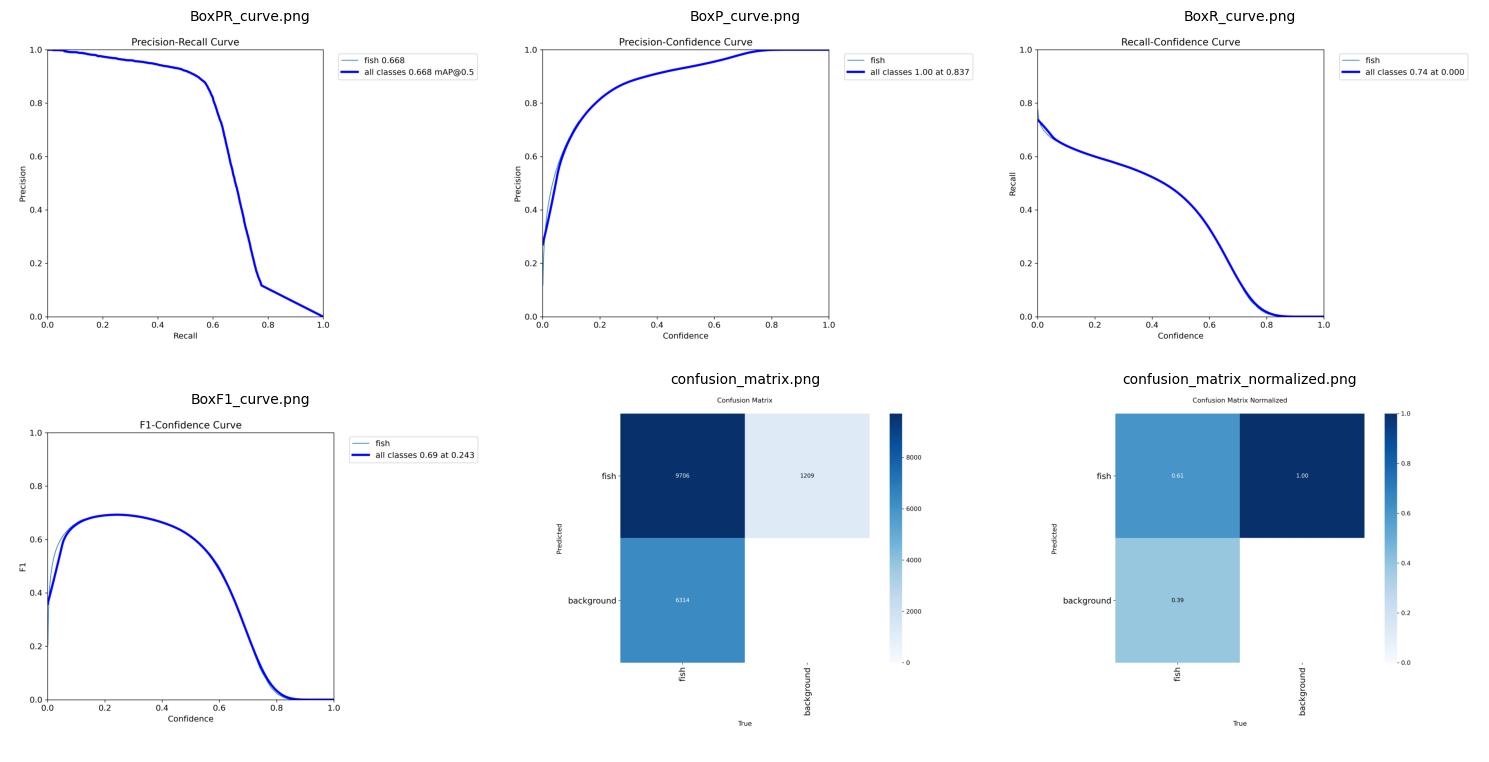

In [5]:
from utils.evaluation_utils import plot_evaluation_metrics

%matplotlib inline

run_dir = "../runs_aquayolo/EVAL_cfc_gray_tiny_m"

plot_evaluation_metrics(run_dir)

### Show predictions

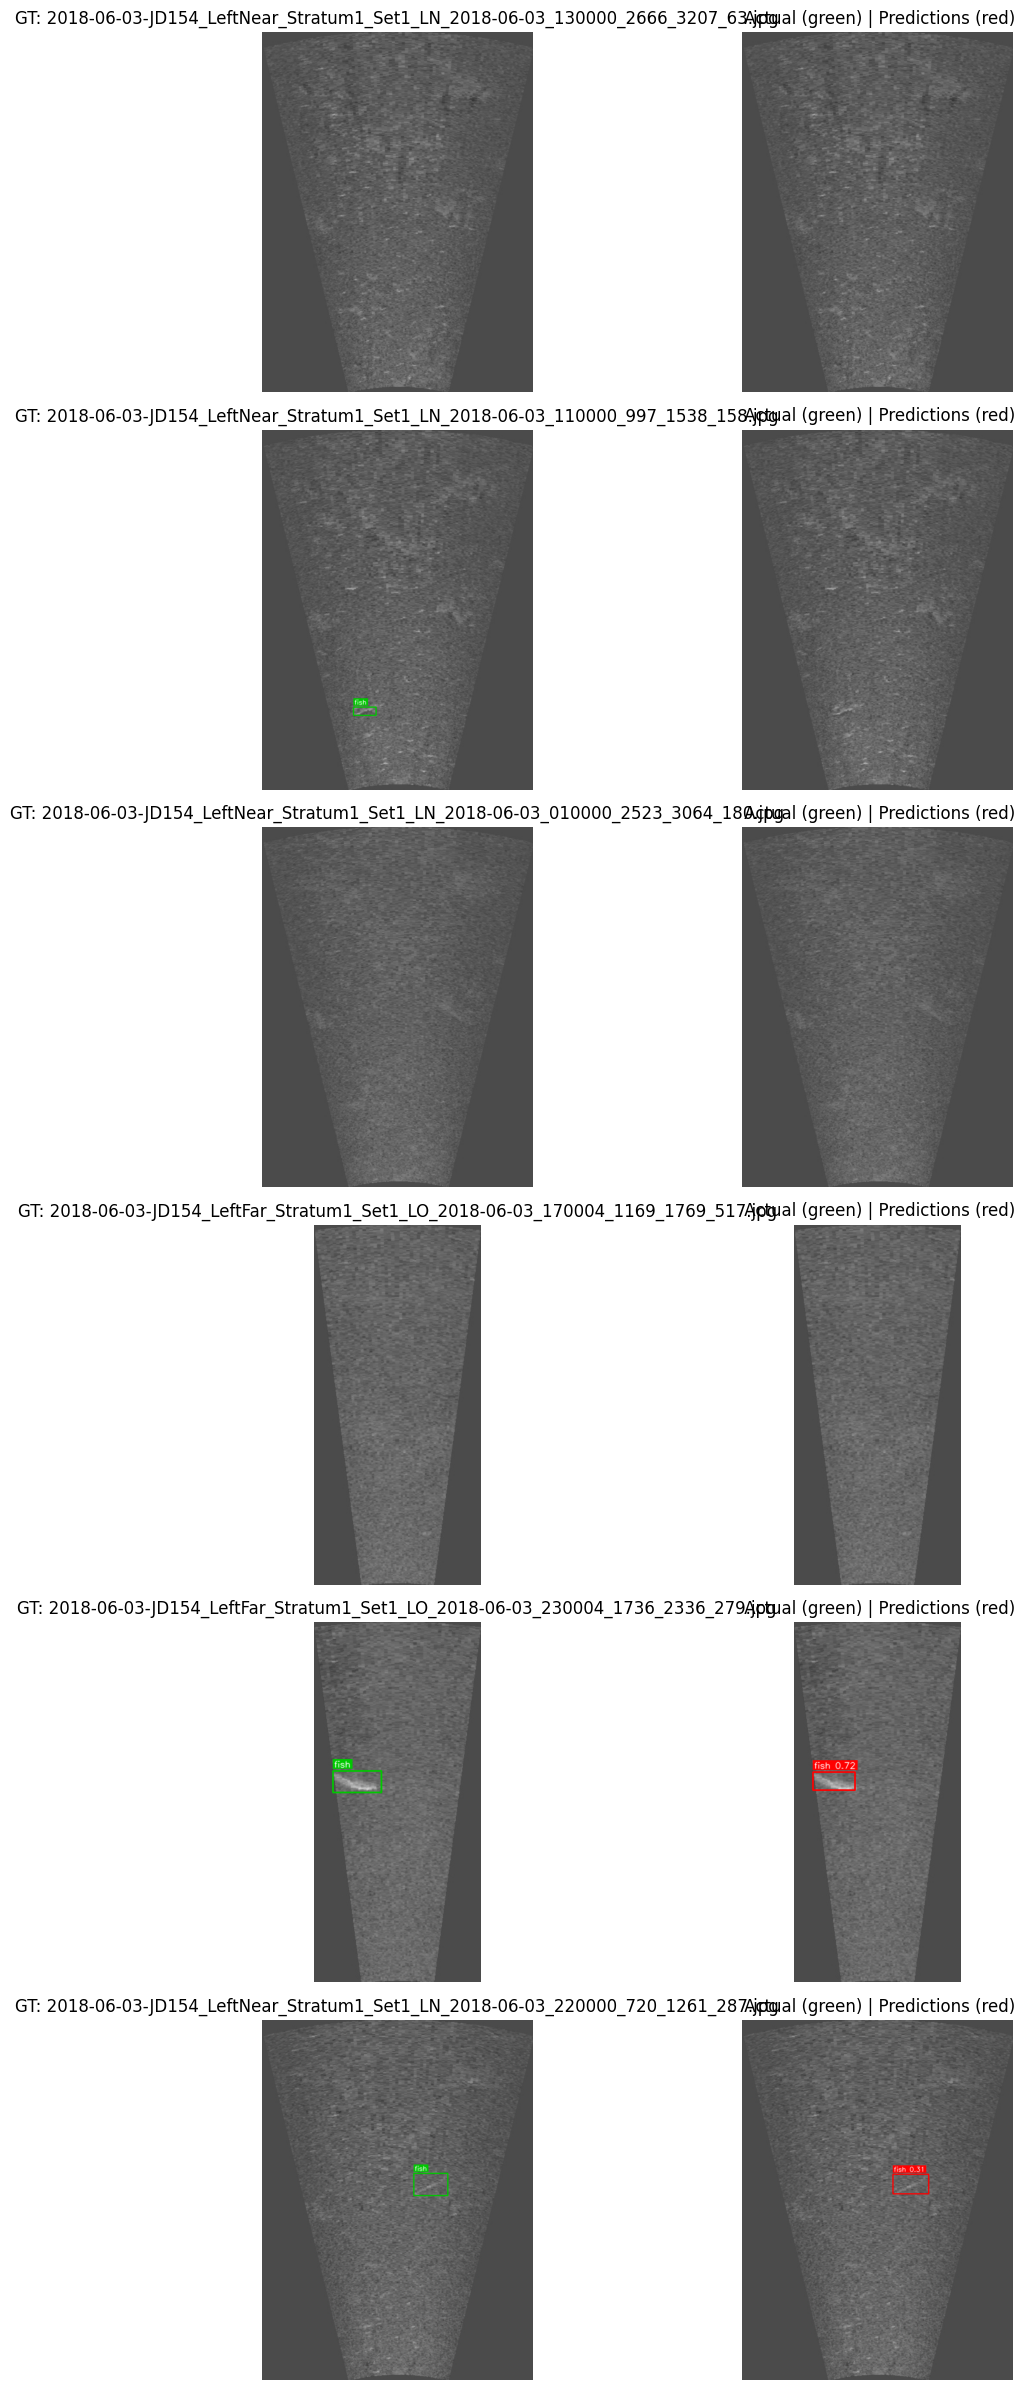

In [8]:
from utils.evaluation_utils import plot_yolo_predictions_samples

plot_yolo_predictions_samples(
    images_dir="../data/CFC_gray_tiny/images/val",
    labels_dir="../data/CFC_gray_tiny/labels/val",
    weights="../runs_aquayolo/cfc_gray_tiny_adamW_m/weights/best.pt",
    num_samples=6,
    conf_thres=0.25,
    imgsz=640
)
